## Loading necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout

## Loading the dataset

In [2]:
df = pd.read_csv("istanbul_stock_exchange.csv")
df.head(5)

,date,TL BASED ISE,USD BASED ISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,9-Jan-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


## Data Preprocessing

In [3]:
df.isnull().sum().sum()

0

In [4]:
df.duplicated().sum()

0

In [5]:
df.dtypes

date              object
TL BASED ISE     float64
USD BASED ISE    float64
SP               float64
DAX              float64
FTSE             float64
NIKKEI           float64
BOVESPA          float64
EU               float64
EM               float64
dtype: object

In [6]:
df['date'] = pd.to_datetime(df['date'])
df['timestamp'] = df['date'].astype('int64') // 10**9
df_numeric = df.drop(columns=['date'])

C:\Users\msaak\AppData\Local\Temp\ipykernel_10172\3938174352.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [7]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numeric)

In [8]:
df_scaled = pd.DataFrame(df_scaled,columns=df_numeric.columns)

In [9]:
df_scaled

,TL BASED ISE,USD BASED ISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM,timestamp
0,0.746889,0.664154,0.404333,0.489969,0.558409,0.451728,0.722875,0.530944,0.776771,0.000000
1,0.668147,0.628741,0.505990,0.546240,0.643736,0.489000,0.618569,0.519229,0.548080,0.001285
2,0.254242,0.314902,0.194024,0.310007,0.248066,0.606576,0.152590,0.273987,0.214765,0.002571
3,0.000000,0.000000,0.470147,0.364884,0.516936,0.093003,0.698163,0.373348,0.221615,0.003856
4,0.549467,0.509203,0.266894,0.291678,0.400483,0.411670,0.374747,0.326501,0.356172,0.005141
...,...,...,...,...,...,...,...,...,...,...
531,0.539854,0.529392,0.493360,0.487558,0.597004,0.502925,0.613904,0.481545,0.481694,0.992288
532,0.545277,0.543299,0.467534,0.459599,0.524650,0.475185,0.472073,0.416335,0.458533,0.993573
533,0.475748,0.448175,0.458172,0.496068,0.514491,0.456817,0.505584,0.426279,0.526836,0.994859
534,0.374650,0.383140,0.273345,0.342305,0.414130,0.463884,0.356235,0.312461,0.435419,0.998715


## Creating Sequences

In [10]:
def create_sequences(data,seqence_length):
    sequences = []
    labels = []
    for i in range(len(data)-seqence_length):
        sequences.append(data[i:i+seqence_length])
        labels.append(data[i+seqence_length])
    return np.array(sequences),np.array(labels)

In [11]:
sequence_length = 10

In [12]:
x,y = create_sequences(df_scaled.values,sequence_length)

## Train - Test - Split

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, shuffle=False)

## Building LSTM Model

In [14]:
model = Sequential([
    LSTM(64,return_sequences=True,input_shape=(sequence_length,x.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

C:\Users\msaak\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [15]:
hist = model.fit(
    xtrain, ytrain,
    validation_data=(xtest, ytest),
    epochs=75,
    batch_size=32,
    verbose=1
)

Epoch 1/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0686 - val_loss: 0.0376
Epoch 2/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0299 - val_loss: 0.0243
Epoch 3/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0261 - val_loss: 0.0244
Epoch 4/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0273 - val_loss: 0.0253
Epoch 5/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0241 - val_loss: 0.0241
Epoch 6/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0255 - val_loss: 0.0241
Epoch 7/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0247 - val_loss: 0.0274
Epoch 8/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0246 - val_loss: 0.0242
Epoch 9/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0212 - val_loss: 0.0240
Epoch 10/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0235 - val_loss: 0.0242
Epoch 11/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0249 - val_loss: 0.0244
Epoch 12/75
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

## Visualization

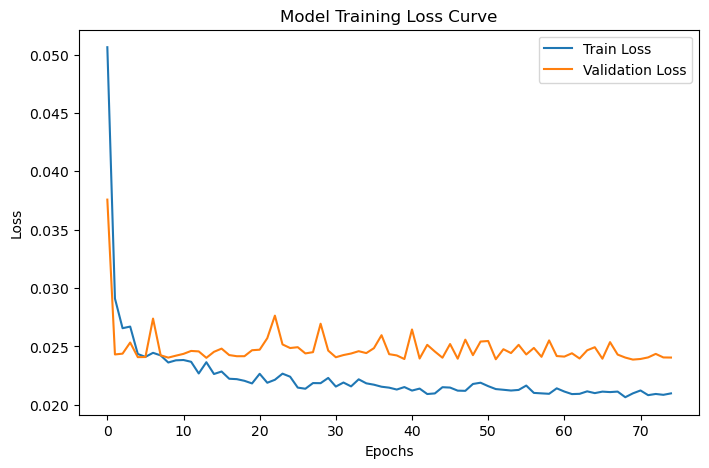

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training Loss Curve')
plt.legend()
plt.show()